In [1]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import geopandas as gpd
import contextily as ctx
import pandas as pd
import seaborn as sns
import rasterio
import numpy as np
import os
from rasterio.windows import from_bounds
from shapely.geometry import Point
from tqdm import tqdm
from pathlib import Path

# .gpkg file

In [3]:
# Path to the .gpkg file 
mahsa_aoi_path = "f&t_mahsa_aoi.gpkg"

# Load GeoPackage
mahsa_aoi = gpd.read_file(mahsa_aoi_path)

# Show first few rows
print(mahsa_aoi.head())

# Print coordinate reference system
print(mahsa_aoi.crs)


                                            geometry
0  MULTIPOLYGON Z (((76 31 0, 77 31 0, 77 30 0, 7...
1  MULTIPOLYGON Z (((75 31 0, 76 31 0, 76 30 0, 7...
EPSG:4326


<Axes: >

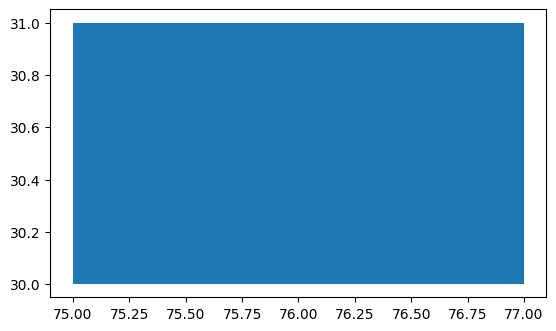

In [4]:
mahsa_aoi.plot()


#  mahsa sites

In [4]:
# Path to the .gpkg file 
mahsa_sites_path = "mahsa_sites_20250707.gpkg"

# Load GeoPackage
mahsa_sites = gpd.read_file(mahsa_sites_path)

# Show first few rows
print(mahsa_sites.head())

# Print coordinate reference system
print(mahsa_sites.crs)


              mahsa_id    heritage_location_classification  \
0  HL-ML-PO0002-000062             Historical Map Features   
1  HL-HM-PO0023-000251  Non Archaeological/Natural Feature   
2  HL-ML-PO0180-000083  Non Archaeological/Natural Feature   
3  HL-ML-PO0180-000091                  No Visible Remains   
4  HL-HM-PO0002-000078           Built/Historical Heritage   

  heritage_location_form heritage_location_interperation  \
0                  Mound                         Unknown   
1                   None                            None   
2                   None                            None   
3                  Mound                         Unknown   
4              Structure                          Temple   

                    geometry  
0  POINT (76.15243 30.69456)  
1  POINT (75.98772 30.70094)  
2  POINT (75.85416 30.66915)  
3  POINT (75.78339 30.77996)  
4  POINT (76.06664 30.71952)  
EPSG:4326


In [6]:
print(mahsa_sites.columns)

Index(['mahsa_id', 'heritage_location_classification',
       'heritage_location_form', 'heritage_location_interperation',
       'geometry'],
      dtype='object')


In [7]:
print(mahsa_ids := mahsa_sites["mahsa_id"].unique())

['HL-ML-PO0002-000062' 'HL-HM-PO0023-000251' 'HL-ML-PO0180-000083'
 'HL-ML-PO0180-000091' 'HL-HM-PO0002-000078' 'HL-HM-PO0023-000252'
 'HL-HM-PO0023-000278' 'HL-HM-PO0023-000253' 'HL-FS-PO0023-000001'
 'HL-ML-PO0002-000065' 'HL-HM-PO0023-000291' 'HL-ML-PO0023-000305'
 'HL-ML-PO0180-000086' 'HL-ML-PO0023-000301' 'HL-HM-PO0002-000067'
 'HL-HM-PO0023-000274' 'HL-HM-PO0023-000265' 'HL-ML-PO0180-000092'
 'HL-ML-PO0180-000089' 'HL-ML-PO0023-000306' 'HL-HM-PO0023-000313'
 'HL-ML-PO0023-000296' 'HL-HM-PO0023-000269' 'HL-HM-PO0023-000290'
 'HL-ML-PO0023-000307' 'HL-HM-PO0023-000311' 'HL-ML-PO0002-000058'
 'HL-HM-PO0023-000250' 'HL-ML-PO0023-000300' 'HL-ML-PO0004-000367'
 'HL-ML-PO0023-000299' 'HL-HM-PO0002-000076' 'HL-HM-PO0023-000259'
 'HL-HM-PO0002-000079' 'HL-ML-PO0004-000368' 'HL-ML-PO0023-000297'
 'HL-HM-PO0023-000239' 'HL-ML-PO0004-000373' 'HL-HM-PO0023-000249'
 'HL-HM-PO0023-000262' 'HL-HM-PO0023-000287' 'HL-HM-PO0023-000272'
 'HL-ML-PO0180-000088' 'HL-ML-PO0004-000372' 'HL-ML-PO0002-000

In [8]:
duplicate_ids = mahsa_sites[mahsa_sites.duplicated(subset='mahsa_id', keep=False)]
print(duplicate_ids)


                mahsa_id    heritage_location_classification  \
7    HL-HM-PO0023-000253  Non Archaeological/Natural Feature   
8    HL-FS-PO0023-000001  Non Archaeological/Natural Feature   
20   HL-HM-PO0023-000313           Built/Historical Heritage   
21   HL-HM-PO0023-000313           Built/Historical Heritage   
37   HL-HM-PO0023-000253  Non Archaeological/Natural Feature   
39   HL-ML-PO0004-000373  Non Archaeological/Natural Feature   
40   HL-HM-PO0023-000249  Non Archaeological/Natural Feature   
74   HL-ML-PO0004-000373  Non Archaeological/Natural Feature   
78   HL-ML-PO0180-000078                  No Visible Remains   
94   HL-HM-PO0023-000249  Non Archaeological/Natural Feature   
95   HL-FS-PO0023-000001  Non Archaeological/Natural Feature   
116  HL-ML-PO0180-000078                  No Visible Remains   

    heritage_location_form heritage_location_interperation  \
7                     None                            None   
8                     None                 

In [9]:
num_duplicates = mahsa_sites['mahsa_id'].duplicated().sum()
print(f"Number of duplicate mahsa_id entries: {num_duplicates}")


Number of duplicate mahsa_id entries: 6


In [10]:
print(mahsa_ids := mahsa_sites["mahsa_id"].nunique())

118


In [11]:
dupes = mahsa_sites['mahsa_id'].value_counts()
print(dupes[dupes > 1])


mahsa_id
HL-FS-PO0023-000001    2
HL-HM-PO0023-000253    2
HL-HM-PO0023-000313    2
HL-ML-PO0004-000373    2
HL-HM-PO0023-000249    2
HL-ML-PO0180-000078    2
Name: count, dtype: int64


In [12]:
# Get IDs that occur more than once
duplicate_ids = mahsa_sites['mahsa_id'].value_counts()
duplicate_ids = duplicate_ids[duplicate_ids > 1].index.tolist()
duplicates_df = mahsa_sites[mahsa_sites['mahsa_id'].isin(duplicate_ids)]
# Function to check if all rows in a group are identical
def has_differences(group):
    return not group.drop(columns=['mahsa_id', 'geometry']).nunique().eq(1).all()

# Filter only groups that have differing content
diff_groups = (
    duplicates_df.groupby('mahsa_id')
    .filter(has_differences)
    .sort_values('mahsa_id')
)
print(diff_groups)
for mahsa_id, group in diff_groups.groupby('mahsa_id'):
    print(f"\n🔍 Differences for mahsa_id: {mahsa_id}")
    print(group.to_string(index=False))  


               mahsa_id    heritage_location_classification  \
8   HL-FS-PO0023-000001  Non Archaeological/Natural Feature   
95  HL-FS-PO0023-000001  Non Archaeological/Natural Feature   
40  HL-HM-PO0023-000249  Non Archaeological/Natural Feature   
94  HL-HM-PO0023-000249  Non Archaeological/Natural Feature   
7   HL-HM-PO0023-000253  Non Archaeological/Natural Feature   
37  HL-HM-PO0023-000253  Non Archaeological/Natural Feature   
20  HL-HM-PO0023-000313           Built/Historical Heritage   
21  HL-HM-PO0023-000313           Built/Historical Heritage   
39  HL-ML-PO0004-000373  Non Archaeological/Natural Feature   
74  HL-ML-PO0004-000373  Non Archaeological/Natural Feature   

   heritage_location_form heritage_location_interperation  \
8                    None                            None   
95                   None                            None   
40                   None                            None   
94                   None                            None   
7

# next column 'heritage_location_classification'

In [13]:
print(heritage_loc := mahsa_sites["heritage_location_classification"].unique())

['Historical Map Features' 'Non Archaeological/Natural Feature'
 'No Visible Remains' 'Built/Historical Heritage'
 'Multi Feature Heritage Sites']


In [14]:
# Display the percentage of each heritage location classification
print("Percentage of each heritage location classification:")
(mahsa_sites["heritage_location_classification"].value_counts(normalize=True) * 100)


Percentage of each heritage location classification:


heritage_location_classification
No Visible Remains                    41.935484
Non Archaeological/Natural Feature    34.677419
Historical Map Features               14.516129
Built/Historical Heritage              8.064516
Multi Feature Heritage Sites           0.806452
Name: proportion, dtype: float64

/tmp/ipykernel_15651/589217255.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=mahsa_sites,


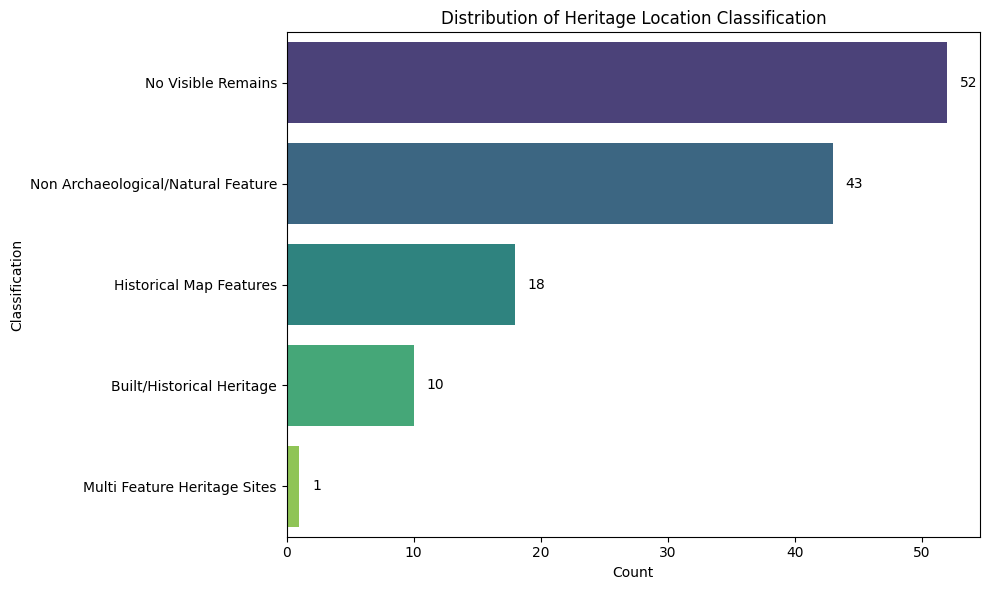

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
ax = sns.countplot(data=mahsa_sites, 
                   y="heritage_location_classification", 
                   order=mahsa_sites["heritage_location_classification"].value_counts().index,
                   palette="viridis")

# Add count labels to each bar
for p in ax.patches:
    count = int(p.get_width())
    y = p.get_y() + p.get_height() / 2
    ax.text(count + 1, y, str(count), va='center', fontsize=10)

plt.title("Distribution of Heritage Location Classification")
plt.xlabel("Count")
plt.ylabel("Classification")
plt.tight_layout()
plt.show()


In [16]:
pd.crosstab(mahsa_sites["heritage_location_classification"], mahsa_sites["heritage_location_form"])


heritage_location_form,Medium Mound,Mound,Multi-Feature,Small Mound,Structure,Structure/s
heritage_location_classification,,,,,,
Built/Historical Heritage,1,2,0,2,3,1
Historical Map Features,0,18,0,0,0,0
Multi Feature Heritage Sites,0,0,1,0,0,0
No Visible Remains,0,5,0,0,0,0
Non Archaeological/Natural Feature,0,4,0,0,0,0


# column geometry

In [21]:
print(geometry := mahsa_sites["geometry"].unique())

<GeometryArray>
[<POINT (76.152 30.695)>, <POINT (75.988 30.701)>, <POINT (75.854 30.669)>,
  <POINT (75.783 30.78)>,  <POINT (76.067 30.72)>, <POINT (75.973 30.702)>,
 <POINT (75.742 30.663)>, <POINT (75.916 30.603)>, <POINT (75.918 30.617)>,
 <POINT (76.187 30.692)>,
 ...
 <POINT (75.934 30.763)>, <POINT (75.925 30.805)>, <POINT (75.767 30.642)>,
 <POINT (75.881 30.663)>, <POINT (75.768 30.657)>, <POINT (75.891 30.625)>,
 <POINT (76.106 30.711)>, <POINT (75.735 30.678)>,  <POINT (75.898 30.63)>,
  <POINT (76.08 30.638)>]
Length: 123, dtype: geometry


In [22]:
from shapely.geometry import Point

# Check if all geometries are of type Point
all_points = mahsa_sites["geometry"].apply(lambda geom: isinstance(geom, Point)).all()

print("Are all geometries Points?", all_points)



Are all geometries Points? True


# column : heritage_location_form

In [23]:
print(heritage_loc_form := mahsa_sites["heritage_location_form"].unique())

['Mound' None 'Structure' 'Multi-Feature' 'Small Mound' 'Structure/s'
 'Medium Mound']


In [24]:
print("Count of each heritage location form:")
print(mahsa_sites["heritage_location_form"].value_counts())


Count of each heritage location form:
heritage_location_form
Mound            29
Structure         3
Small Mound       2
Multi-Feature     1
Structure/s       1
Medium Mound      1
Name: count, dtype: int64


In [25]:
none_count = mahsa_sites["heritage_location_form"].isnull().sum()
print(f"Number of None (missing) values: {none_count}")


Number of None (missing) values: 87


/tmp/ipykernel_13403/3677775442.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=mahsa_sites,


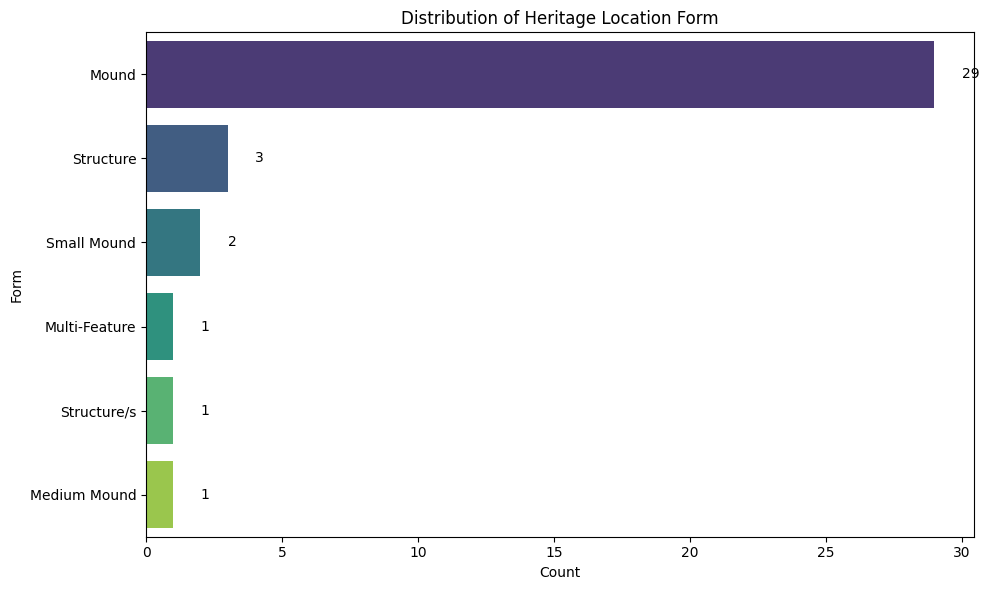

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
ax = sns.countplot(data=mahsa_sites, 
                   y="heritage_location_form", 
                   order=mahsa_sites["heritage_location_form"].value_counts().index,
                   palette="viridis")

# Add count labels to each bar
for p in ax.patches:
    count = int(p.get_width())
    y = p.get_y() + p.get_height() / 2
    ax.text(count + 1, y, str(count), va='center', fontsize=10)

plt.title("Distribution of Heritage Location Form")
plt.xlabel("Count")
plt.ylabel("Form")
plt.tight_layout()
plt.show()


# column : heritage_location_interperation

In [27]:
print(heritage_loc_interpret := mahsa_sites["heritage_location_interperation"].unique())

print("Count of each heritage location interperation:")
print(mahsa_sites["heritage_location_interperation"].value_counts())

none_count_interperation = mahsa_sites["heritage_location_interperation"].isnull().sum()
print(f"Number of None (missing) values: {none_count_interperation}")


['Unknown' None 'Temple' 'Settlement Site' 'Shrine'
 'Settlement/Habitation Site' 'Fort/Fortress' 'Religious Complex'
 'Tomb/Grave/Burial']
Count of each heritage location interperation:
heritage_location_interperation
Unknown                       27
Religious Complex              3
Temple                         2
Settlement Site                1
Shrine                         1
Settlement/Habitation Site     1
Fort/Fortress                  1
Tomb/Grave/Burial              1
Name: count, dtype: int64
Number of None (missing) values: 87


/tmp/ipykernel_13403/3922875441.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=mahsa_sites,


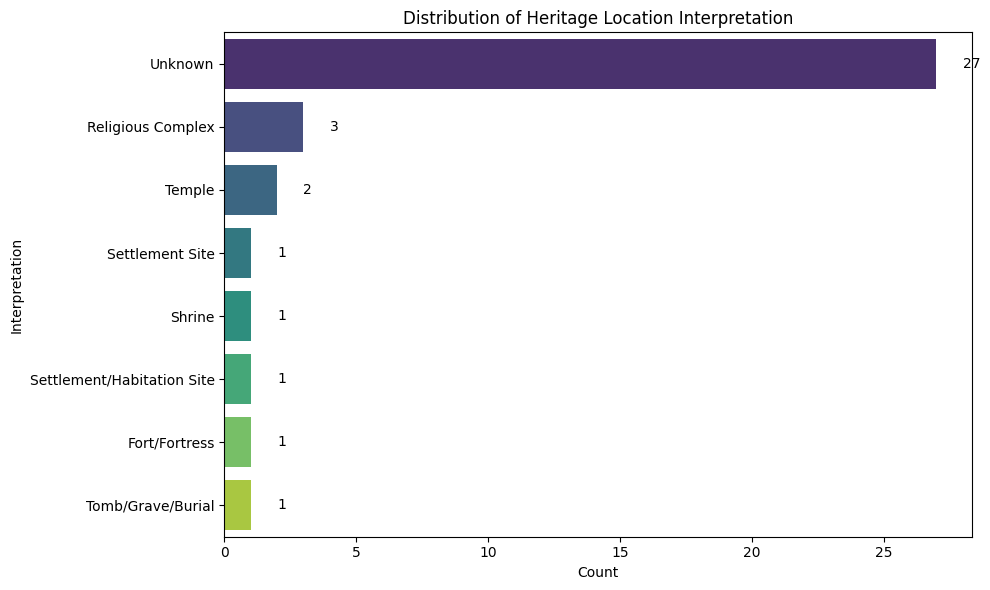

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
ax = sns.countplot(data=mahsa_sites, 
                   y="heritage_location_interperation", 
                   order=mahsa_sites["heritage_location_interperation"].value_counts().index,
                   palette="viridis")

# Add count labels to each bar
for p in ax.patches:
    count = int(p.get_width())
    y = p.get_y() + p.get_height() / 2
    ax.text(count + 1, y, str(count), va='center', fontsize=10)

plt.title("Distribution of Heritage Location Interpretation")
plt.xlabel("Count")
plt.ylabel("Interpretation")
plt.tight_layout()
plt.show()


<Axes: >

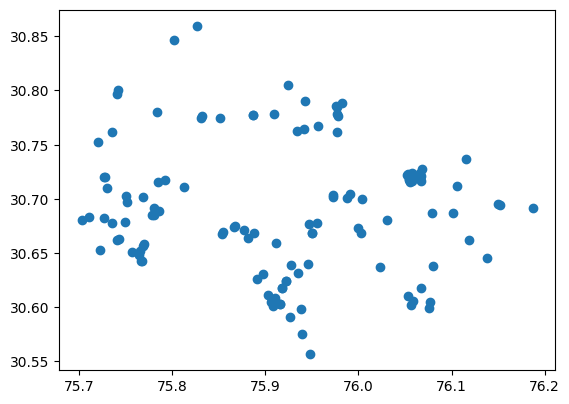

In [29]:
mahsa_sites.plot()

# plotting on the world map

In [30]:
# pip install contextily


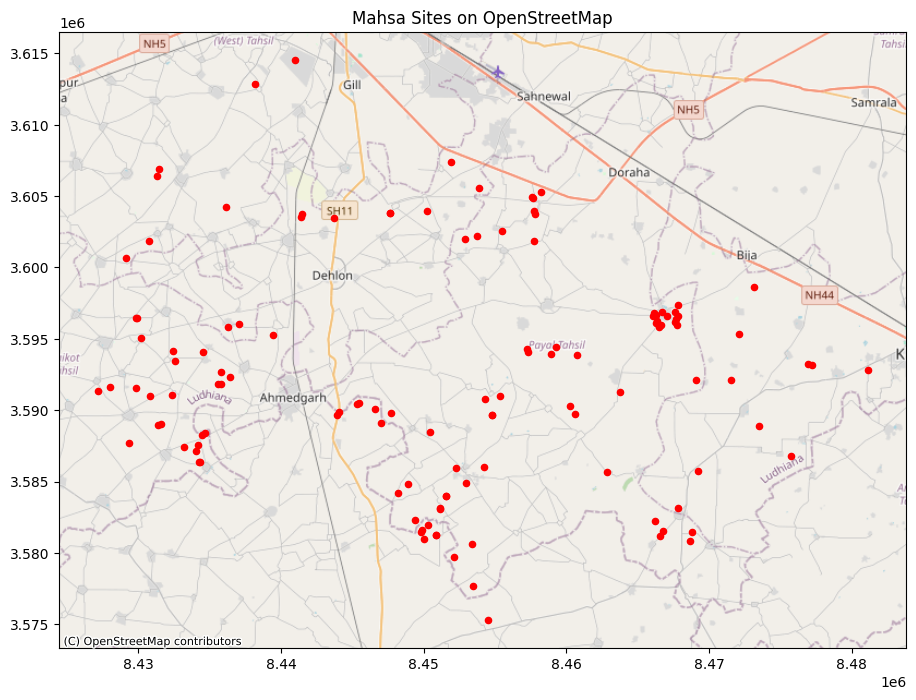

In [31]:
# Convert to Web Mercator for tile compatibility
mahsa_sites = mahsa_sites.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
mahsa_sites.plot(ax=ax, color='red', markersize=20)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title("Mahsa Sites on OpenStreetMap")
plt.show()


# .shp file

   FID                                           geometry
0    0  POLYGON Z ((76 31 0, 77 31 0, 77 30 0, 76 30 0...
1    1  POLYGON Z ((75 31 0, 76 31 0, 76 30 0, 75 30 0...
EPSG:4326


<Axes: >

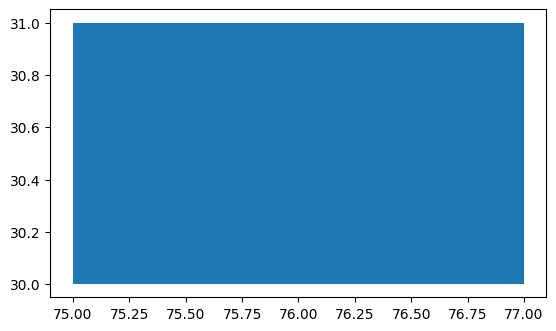

In [5]:
# Path to the shapefile
shp_path = "MAHSA_AOI_F&T.shp"

# Load shapefile
gdf_shp = gpd.read_file(shp_path)

# Show first few rows
print(gdf_shp.head())

# Print coordinate reference system
print(gdf_shp.crs)
gdf_shp.plot()

# .tar.gz file

In [6]:
import tarfile

# Path to .tar.gz file
tar_path = "/home/snehal/Downloads/MAHSA_AOI_F&T/dims_op_oc_dfd2_691419231_1.tar.gz"

# Extract to a folder
extract_folder = "extracted_tar_1"

with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=extract_folder)

print(f"Extracted files to: {extract_folder}")


Extracted files to: extracted_tar_1


In [7]:
files = os.listdir("extracted_tar_1")
print(files)

['dims_op_oc_dfd2_691419231_1']


In [8]:
inner_folder = "extracted_tar_1/dims_op_oc_dfd2_691419231_1"
inner_files = os.listdir(inner_folder)
print(inner_files)


['readme.html', 'TDM.DEM.DEM', 'tools']


In [9]:
from bs4 import BeautifulSoup

# Path to the HTML file
html_path = "extracted_tar_1/dims_op_oc_dfd2_691419231_1/readme.html"

# Read and parse the HTML
with open(html_path, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "html.parser")

# Extract and print plain text
text = soup.get_text(separator="\n", strip=True)
print(text)  # Show first 2000 characters


dims_op_oc_dfd2_691419229
ADMINISTRATIVE DATA
Order 
                                       ID
dims_op_oc_dfd2_691419229
Package 
                                       ID
dims_op_oc_dfd2_691419231
Volume 
                                       No.
1/
                                          		   20
Production 
                                       Date
2022-07-19
Volume 
                                 Content
This 
                                 data collection has
been
produced
as a service of
DLR 
                                 - DFD
Copyright ©
                           2022 DLR
No.
Product Type
Product Reference 
                  ID
Volume
Path
©
1
TDM.DEM.DEM
dims_op_pl_dfd_XXXXB00000000475928935935
9
TDM.DEM.DEM/TDM1_DEM__04_N25E065_V02_C
©
TDM/DEM/DEM/0.4/65/25/66/26/2/COMPLETED
2
TDM.DEM.DEM
dims_op_pl_dfd_XXXXB00000000377612081138
11
TDM.DEM.DEM/TDM1_DEM__04_N25E066_V01_C
©
TDM/DEM/DEM/0.4/66/25/67/26/1/COMPLETED
3
TDM.DEM.DEM
dims_op_pl_dfd_XXXXB0000000037761208096

In [10]:
import tarfile

# Path to your .tar.gz file
tar_path = "/home/snehal/Downloads/MAHSA_AOI_F&T/dims_op_oc_dfd2_691419231_3.tar.gz"

# Extract to a folder
extract_folder = "extracted_tar_2"

with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=extract_folder)

print(f"Extracted files to: {extract_folder}")


Extracted files to: extracted_tar_2


In [11]:
files = os.listdir("extracted_tar_2")
print(files)


['dims_op_oc_dfd2_691419231_3']


In [24]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [12]:
mahsa_sites

,mahsa_id,heritage_location_classification,heritage_location_form,heritage_location_interperation,geometry
0,HL-ML-PO0002-000062,Historical Map Features,Mound,Unknown,POINT (76.15243 30.69456)
1,HL-HM-PO0023-000251,Non Archaeological/Natural Feature,None,None,POINT (75.98772 30.70094)
2,HL-ML-PO0180-000083,Non Archaeological/Natural Feature,None,None,POINT (75.85416 30.66915)
3,HL-ML-PO0180-000091,No Visible Remains,Mound,Unknown,POINT (75.78339 30.77996)
4,HL-HM-PO0002-000078,Built/Historical Heritage,Structure,Temple,POINT (76.06664 30.71952)
...,...,...,...,...,...
119,HL-HM-PO0023-000288,No Visible Remains,None,None,POINT (75.89125 30.62532)
120,HL-ML-PO0002-000059,Historical Map Features,Mound,Unknown,POINT (76.10611 30.71144)
121,HL-HM-PO0023-000276,Non Archaeological/Natural Feature,None,None,POINT (75.73524 30.67793)
122,HL-HM-PO0023-000310,No Visible Remains,None,None,POINT (75.89755 30.63005)


In [15]:
mahsa_sites_geometry=mahsa_sites['geometry']
mahsa_sites_geometry 

0      POINT (76.15243 30.69456)
1      POINT (75.98772 30.70094)
2      POINT (75.85416 30.66915)
3      POINT (75.78339 30.77996)
4      POINT (76.06664 30.71952)
                 ...            
119    POINT (75.89125 30.62532)
120    POINT (76.10611 30.71144)
121    POINT (75.73524 30.67793)
122    POINT (75.89755 30.63005)
123    POINT (76.08008 30.63751)
Name: geometry, Length: 124, dtype: geometry

In [27]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [13]:
def assign_elevation_to_points_3d(gdf, dem_tile_75, dem_tile_76):
    """
    Assign elevation to each point and convert 2D geometry to 3D Point(x, y, z)

    Parameters:
        gdf (GeoDataFrame): GeoDataFrame with 2D Point geometries in EPSG:4326
        dem_tile_75 (str): Path to DEM tile covering longitude 75
        dem_tile_76 (str): Path to DEM tile covering longitude 76

    Returns:
        GeoDataFrame with 3D Point geometries
    """
    dem75 = rasterio.open(dem_tile_75)
    dem76 = rasterio.open(dem_tile_76)

    new_geoms = []

    for point in gdf.geometry:
        lon, lat = point.x, point.y

        # Choose the correct DEM
        if 75 <= lon < 76:
            dem = dem75
        elif 76 <= lon < 77:
            dem = dem76
        else:
            new_geoms.append(Point(lon, lat, np.nan))
            continue

        # Sample elevation
        try:
            value = next(dem.sample([(lon, lat)]))[0]
            elevation = float(value) if value is not None else np.nan
        except:
            elevation = np.nan

        # Create 3D point
        new_geoms.append(Point(lon, lat, elevation))

    # Replace geometry with 3D Points
    gdf["geometry"] = new_geoms
    return gdf


In [16]:
if mahsa_sites_geometry.crs != "EPSG:4326":
    print('no')
else :
    print('yes')

yes


In [17]:
# Ensure CRS is EPSG:4326 (WGS 84)
mahsa_sites = mahsa_sites.to_crs("EPSG:4326")


In [18]:
if mahsa_sites.crs != "EPSG:4326":
    print('no')
else :
    print('yes')

yes


In [19]:
# Load the archaeological site GeoDataFrame
#mahsa_sites = gpd.read_file("your_sites_file.geojson")  # or .shp or .gpkg
mahsa_sites_geometry = mahsa_sites["geometry"].to_list()

# Define paths to DEM tiles
dem_path_75 = "/home/snehal/Downloads/MAHSA_AOI_F&T/extracted_tar_1/dims_op_oc_dfd2_691419231_1/TDM.DEM.DEM/TDM1_DEM__04_N30E075_V01_C/DEM/TDM1_DEM__04_N30E075_DEM.tif"
dem_path_76 = "/home/snehal/Downloads/MAHSA_AOI_F&T/extracted_tar_2/dims_op_oc_dfd2_691419231_3/TDM.DEM.DEM/TDM1_DEM__04_N30E076_V01_C/DEM/TDM1_DEM__04_N30E076_DEM.tif"

# Assign elevation
mahsa_sites_3d = assign_elevation_to_points_3d(mahsa_sites, dem_path_75, dem_path_76)

# Save the result (optional)
mahsa_sites_3d.to_file("mahsa_sites_with_elevation.geojson", driver="GeoJSON")


In [33]:
mahsa_sites_3d

,mahsa_id,heritage_location_classification,heritage_location_form,heritage_location_interperation,geometry
0,HL-ML-PO0002-000062,Historical Map Features,Mound,Unknown,POINT Z (76.15243 30.69456 212.35017)
1,HL-HM-PO0023-000251,Non Archaeological/Natural Feature,None,None,POINT Z (75.98772 30.70094 209.17195)
2,HL-ML-PO0180-000083,Non Archaeological/Natural Feature,None,None,POINT Z (75.85416 30.66915 207.35658)
3,HL-ML-PO0180-000091,No Visible Remains,Mound,Unknown,POINT Z (75.78339 30.77996 199.31081)
4,HL-HM-PO0002-000078,Built/Historical Heritage,Structure,Temple,POINT Z (76.06664 30.71952 209.70354)
...,...,...,...,...,...
119,HL-HM-PO0023-000288,No Visible Remains,None,None,POINT Z (75.89125 30.62532 199.86069)
120,HL-ML-PO0002-000059,Historical Map Features,Mound,Unknown,POINT Z (76.10611 30.71144 212.12959)
121,HL-HM-PO0023-000276,Non Archaeological/Natural Feature,None,None,POINT Z (75.73524 30.67793 197.2524)
122,HL-HM-PO0023-000310,No Visible Remains,None,None,POINT Z (75.89755 30.63005 200.39871)


In [25]:
mahsa_sites_3d['geometry']

0      POINT Z (76.15243 30.69456 212.35017)
1      POINT Z (75.98772 30.70094 209.17195)
2      POINT Z (75.85416 30.66915 207.35658)
3      POINT Z (75.78339 30.77996 199.31081)
4      POINT Z (76.06664 30.71952 209.70354)
                       ...                  
119    POINT Z (75.89125 30.62532 199.86069)
120    POINT Z (76.10611 30.71144 212.12959)
121     POINT Z (75.73524 30.67793 197.2524)
122    POINT Z (75.89755 30.63005 200.39871)
123    POINT Z (76.08008 30.63751 206.35312)
Name: geometry, Length: 124, dtype: geometry

In [34]:
pd.crosstab(mahsa_sites_3d['heritage_location_classification'], mahsa_sites_3d['heritage_location_form'])


heritage_location_form,Medium Mound,Mound,Multi-Feature,Small Mound,Structure,Structure/s
heritage_location_classification,,,,,,
Built/Historical Heritage,1,2,0,2,3,1
Historical Map Features,0,18,0,0,0,0
Multi Feature Heritage Sites,0,0,1,0,0,0
No Visible Remains,0,5,0,0,0,0
Non Archaeological/Natural Feature,0,4,0,0,0,0


<Axes: xlabel='heritage_location_form', ylabel='heritage_location_classification'>

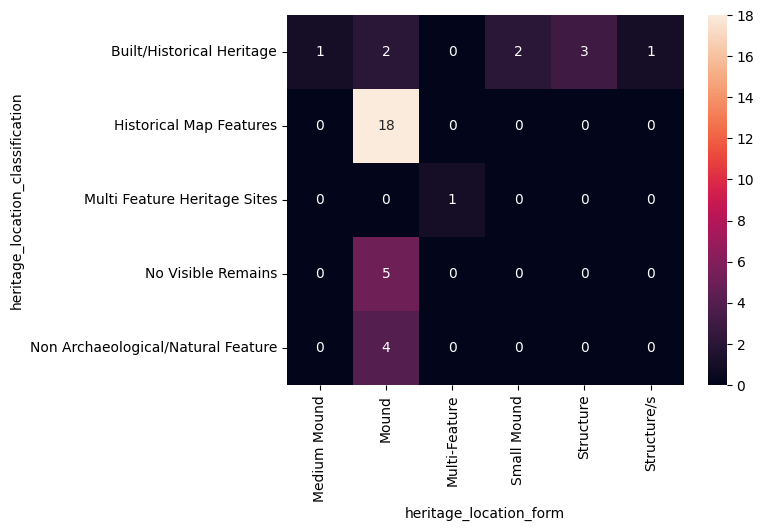

In [35]:
import seaborn as sns
sns.heatmap(pd.crosstab(mahsa_sites_3d['heritage_location_classification'], mahsa_sites_3d['heritage_location_form']), annot=True, fmt='d')


<Axes: >

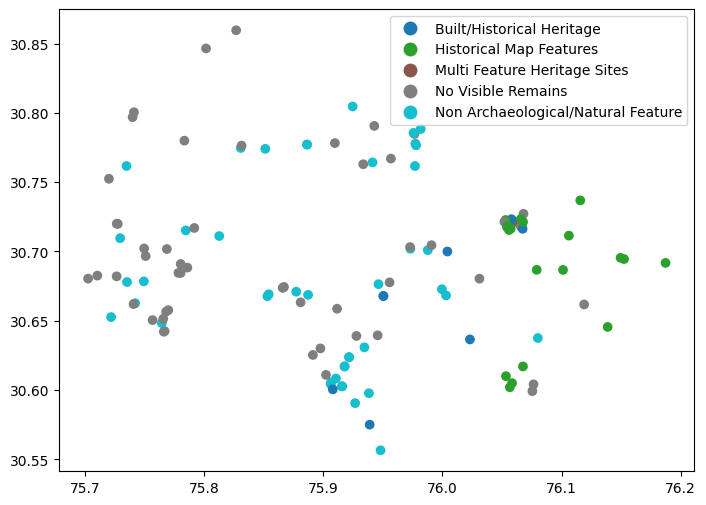

In [36]:
import geopandas as gpd
import matplotlib.pyplot as plt

  # or convert your DataFrame with `gpd.GeoDataFrame()`
mahsa_sites_3d.plot(column='heritage_location_classification', legend=True, figsize=(10, 6))


<Axes: xlabel='heritage_location_form', ylabel='elevation'>

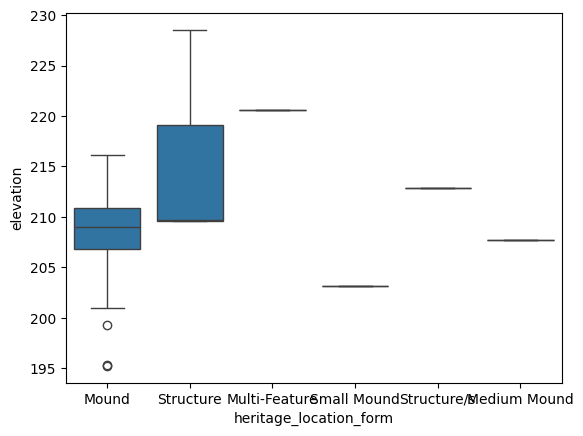

In [37]:
mahsa_sites_3d['elevation'] = mahsa_sites_3d['geometry'].apply(lambda x: x.z) 

sns.boxplot(x='heritage_location_form', y='elevation', data=mahsa_sites_3d)


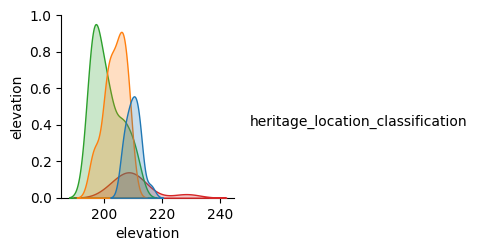

In [38]:
import seaborn as sns
sns.pairplot(mahsa_sites_3d, hue='heritage_location_classification', vars=['elevation'])


In [39]:
mahsa_sites_3d.groupby('heritage_location_classification')['heritage_location_form'].apply(lambda x: x.isna().mean())


heritage_location_classification
Built/Historical Heritage             0.100000
Historical Map Features               0.000000
Multi Feature Heritage Sites          0.000000
No Visible Remains                    0.903846
Non Archaeological/Natural Feature    0.906977
Name: heritage_location_form, dtype: float64

In [40]:
mahsa_sites_3d


,mahsa_id,heritage_location_classification,heritage_location_form,heritage_location_interperation,geometry,elevation
0,HL-ML-PO0002-000062,Historical Map Features,Mound,Unknown,POINT Z (76.15243 30.69456 212.35017),212.350174
1,HL-HM-PO0023-000251,Non Archaeological/Natural Feature,None,None,POINT Z (75.98772 30.70094 209.17195),209.171951
2,HL-ML-PO0180-000083,Non Archaeological/Natural Feature,None,None,POINT Z (75.85416 30.66915 207.35658),207.356583
3,HL-ML-PO0180-000091,No Visible Remains,Mound,Unknown,POINT Z (75.78339 30.77996 199.31081),199.310806
4,HL-HM-PO0002-000078,Built/Historical Heritage,Structure,Temple,POINT Z (76.06664 30.71952 209.70354),209.703537
...,...,...,...,...,...,...
119,HL-HM-PO0023-000288,No Visible Remains,None,None,POINT Z (75.89125 30.62532 199.86069),199.860687
120,HL-ML-PO0002-000059,Historical Map Features,Mound,Unknown,POINT Z (76.10611 30.71144 212.12959),212.129593
121,HL-HM-PO0023-000276,Non Archaeological/Natural Feature,None,None,POINT Z (75.73524 30.67793 197.2524),197.252396
122,HL-HM-PO0023-000310,No Visible Remains,None,None,POINT Z (75.89755 30.63005 200.39871),200.398712


# to make a patch around the points 100m*100m

In [20]:
def extract_patch_from_dem(dem, lon, lat, patch_size_m=200):
    """
    Extract a 3D patch centered at (lon, lat) from the given DEM.
    
    Returns Nx3 numpy array or None if failed.
    """
    try:
        # Convert lon, lat to the DEM's CRS
        transform = dem.transform
        dem_crs = dem.crs
        if dem_crs.to_epsg() == 4326:
            # Geographic CRS — need to estimate meters
            pixel_size = 0.000108  # Roughly ~12 m at equator
            half_size_deg = (patch_size_m / 2) * pixel_size / 12
            xmin = lon - half_size_deg
            xmax = lon + half_size_deg
            ymin = lat - half_size_deg
            ymax = lat + half_size_deg
        else:
            # Projected CRS (meters)
            half = patch_size_m / 2
            xmin, xmax = lon - half, lon + half
            ymin, ymax = lat - half, lat + half

        # Read patch window
        window = from_bounds(xmin, ymin, xmax, ymax, transform)
        patch = dem.read(1, window=window)

        # Get pixel coordinates
        rows, cols = patch.shape
        xs = np.linspace(xmin, xmax, cols)
        ys = np.linspace(ymax, ymin, rows)
        x_grid, y_grid = np.meshgrid(xs, ys)
        xyz = np.column_stack([x_grid.flatten(), y_grid.flatten(), patch.flatten()])

        return xyz
    except Exception as e:
        print(f"Failed to extract patch at ({lon}, {lat}): {e}")
        return None


def attach_patches_to_points(gdf, dem_tile_75, dem_tile_76, patch_size_m=200):
    """
    Adds a column 'elevation_patch' to GeoDataFrame, each row containing Nx3 array.
    """
    # Open DEMs
    dem75 = rasterio.open(dem_tile_75)
    dem76 = rasterio.open(dem_tile_76)

    patches = []
    new_geometries = []

    print("⏳ Extracting patches...")
    for pt in tqdm(gdf.geometry):
        lon, lat = pt.x, pt.y

        # Choose DEM
        if 75 <= lon < 76:
            dem = dem75
        elif 76 <= lon < 77:
            dem = dem76
        else:
            patches.append(None)
            new_geometries.append(Point(lon, lat, np.nan))
            continue

        # Sample elevation at point for 3D geometry
        try:
            value = next(dem.sample([(lon, lat)]))[0]
            elevation = float(value) if value is not None else np.nan
        except:
            elevation = np.nan

        new_geometries.append(Point(lon, lat, elevation))

        # Extract 3D patch
        patch_xyz = extract_patch_from_dem(dem, lon, lat, patch_size_m=patch_size_m)
        patches.append(patch_xyz)

    # Attach results
    gdf["geometry"] = new_geometries
    gdf["elevation_patch"] = patches

    return gdf


In [58]:
"""from pathlib import Path
# Apply the patch extraction
mahsa_sites_with_patches = attach_patches_to_points(mahsa_sites, dem_path_75, dem_path_76, patch_size_m=100)

# Optional: Save to GeoPackage or GeoJSON
mahsa_sites_with_patches.to_file("mahsa_sites_with_elevation_patches.gpkg", driver="GPKG")
"""

'from pathlib import Path\n# Apply the patch extraction\nmahsa_sites_with_patches = attach_patches_to_points(mahsa_sites, dem_path_75, dem_path_76, patch_size_m=100)\n\n# Optional: Save to GeoPackage or GeoJSON\nmahsa_sites_with_patches.to_file("mahsa_sites_with_elevation_patches.gpkg", driver="GPKG")\n'

# doing all in one go is failing again and agian on trying for both 100 or 200 so now trying to process it in chunks 

In [21]:


def process_in_batches(gdf, dem_75, dem_76, batch_size=2):
    """
    Process gdf in batches and attach elevation patches incrementally.
    """
    batches = []
    total = len(gdf)

    for i in range(0, total, batch_size):
        print(f"\n🔹 Processing batch {i} to {min(i+batch_size, total)-1}...")
        gdf_batch = gdf.iloc[i:i+batch_size].copy()

        try:
            result = attach_patches_to_points(gdf_batch, dem_75, dem_76, patch_size_m=100)
            batches.append(result)
        except Exception as e:
            print(f" Batch {i}–{i+batch_size} failed: {e}")

    # Combine all results
    merged = gpd.GeoDataFrame(pd.concat(batches, ignore_index=True), crs=gdf.crs)
    return merged


In [ ]:
# Process in batches
final_result = process_in_batches(mahsa_sites_3d, dem_path_75, dem_path_76, batch_size=2)

# Save result
final_result.to_file("mahsa_sites_with_elevation_patches_batched.gpkg", driver="GPKG")



🔹 Processing batch 0 to 1...
⏳ Extracting patches...


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]



🔹 Processing batch 2 to 3...
⏳ Extracting patches...


100%|██████████| 2/2 [00:03<00:00,  1.98s/it]



🔹 Processing batch 4 to 5...
⏳ Extracting patches...


100%|██████████| 2/2 [00:07<00:00,  3.87s/it]



🔹 Processing batch 6 to 7...
⏳ Extracting patches...


  0%|          | 0/2 [00:00<?, ?it/s]

# it is getting stuck again and again , so trying to identify the bad points 

In [22]:
# Pre-check lon/lat range
for i, pt in enumerate(mahsa_sites_3d.geometry):
    lon, lat = pt.x, pt.y
    if not (75 <= lon < 77):
        print(f"Point {i} out of DEM coverage: {lon}, {lat}")


In [23]:
for i, pt in enumerate(mahsa_sites_3d.geometry):
    if pt is None or not pt.is_valid:
        print(f"Point {i} is missing or invalid")


In [45]:
mahsa_sites_3d

,mahsa_id,heritage_location_classification,heritage_location_form,heritage_location_interperation,geometry,elevation
0,HL-ML-PO0002-000062,Historical Map Features,Mound,Unknown,POINT Z (76.15243 30.69456 212.35017),212.350174
1,HL-HM-PO0023-000251,Non Archaeological/Natural Feature,None,None,POINT Z (75.98772 30.70094 209.17195),209.171951
2,HL-ML-PO0180-000083,Non Archaeological/Natural Feature,None,None,POINT Z (75.85416 30.66915 207.35658),207.356583
3,HL-ML-PO0180-000091,No Visible Remains,Mound,Unknown,POINT Z (75.78339 30.77996 199.31081),199.310806
4,HL-HM-PO0002-000078,Built/Historical Heritage,Structure,Temple,POINT Z (76.06664 30.71952 209.70354),209.703537
...,...,...,...,...,...,...
119,HL-HM-PO0023-000288,No Visible Remains,None,None,POINT Z (75.89125 30.62532 199.86069),199.860687
120,HL-ML-PO0002-000059,Historical Map Features,Mound,Unknown,POINT Z (76.10611 30.71144 212.12959),212.129593
121,HL-HM-PO0023-000276,Non Archaeological/Natural Feature,None,None,POINT Z (75.73524 30.67793 197.2524),197.252396
122,HL-HM-PO0023-000310,No Visible Remains,None,None,POINT Z (75.89755 30.63005 200.39871),200.398712


In [46]:
print(mahsa_sites_3d["geometry"].apply(lambda p: p.has_z if p else False).value_counts())

geometry
True    124
Name: count, dtype: int64


In [47]:
pt = mahsa_sites_3d.geometry.iloc[6]
lon, lat = pt.x, pt.y

# Try sampling manually
with rasterio.open(dem_path_75 if lon < 76 else dem_path_76) as src:
    value = next(src.sample([(lon, lat)]))[0]
    print(f"Elevation at point 6: {value}")

Elevation at point 6: 197.5426025390625


In [24]:
def attach_patches_to_points_l(gdf, dem_tile_75, dem_tile_76, patch_size_m=50):
    import warnings
    warnings.filterwarnings("ignore")

    import rasterio
    from shapely.geometry import Point
    from tqdm import tqdm
    import numpy as np

    dem75 = rasterio.open(dem_tile_75)
    dem76 = rasterio.open(dem_tile_76)

    bounds_75 = dem75.bounds
    bounds_76 = dem76.bounds

    # Convert patch size from meters to degrees if needed
    patch_size_deg = 0.004  # approx 12m/pixel × 0.000108°/pixel × ~37 pixels ≈ 200m

    def is_patch_within_bounds(lon, lat, patch_size_deg, dem_bounds):
        half = patch_size_deg / 2
        return (
            lon - half >= dem_bounds.left and
            lon + half <= dem_bounds.right and
            lat - half >= dem_bounds.bottom and
            lat + half <= dem_bounds.top
        )

    patches = []
    new_geometries = []

    print("⏳ Extracting patches...")
    for idx, pt in enumerate(tqdm(gdf.geometry)):
        try:
            lon, lat = pt.x, pt.y

            if not (70 <= lon <= 80 and 25 <= lat <= 35):  # sanity check
                print(f"⚠️ Point {idx} seems outside India bounds: ({lon}, {lat})")
                patches.append(None)
                new_geometries.append(Point(lon, lat, np.nan))
                continue

            # Choose DEM and bounds
            if 75 <= lon < 76:
                dem = dem75
                bounds = bounds_75
            elif 76 <= lon < 77:
                dem = dem76
                bounds = bounds_76
            else:
                print(f"⚠️ Point {idx} does not fall in DEM tiles: ({lon}, {lat})")
                patches.append(None)
                new_geometries.append(Point(lon, lat, np.nan))
                continue

            # Check if patch around the point fits within DEM
            if not is_patch_within_bounds(lon, lat, patch_size_deg, bounds):
                print(f"⚠️ Skipping point {idx} — patch around ({lon}, {lat}) exceeds DEM bounds")
                patches.append(None)
                new_geometries.append(Point(lon, lat, np.nan))
                continue

            # Sample elevation
            try:
                value = next(dem.sample([(lon, lat)]))[0]
                elevation = float(value) if value is not None else np.nan
            except Exception as e:
                print(f"⚠️ DEM sampling failed at point {idx}: {e}")
                elevation = np.nan

            new_geometries.append(Point(lon, lat, elevation))

            # Extract patch
            patch_xyz = extract_patch_from_dem(dem, lon, lat, patch_size_m=patch_size_m)
            if patch_xyz is None:
                print(f"⚠️ Patch extraction failed at point {idx}")
            patches.append(patch_xyz)

        except Exception as e:
            print(f"🚨 Unexpected failure at point {idx}: {e}")
            patches.append(None)
            new_geometries.append(Point(pt.x, pt.y, np.nan))

    gdf["geometry"] = new_geometries
    gdf["elevation_patch"] = patches
    return gdf

In [ ]:
mahsa_sites_3d.iloc[6:8]

,mahsa_id,heritage_location_classification,heritage_location_form,heritage_location_interperation,geometry
6,HL-HM-PO0023-000278,Non Archaeological/Natural Feature,None,None,POINT Z (75.74208 30.66267 197.5426)
7,HL-HM-PO0023-000253,Non Archaeological/Natural Feature,None,None,POINT Z (75.91575 30.60264 202.98697)


In [25]:
import geopandas as gpd
import pandas as pd
import gc
from tqdm import tqdm

def process_in_batches_low_memory(gdf, dem_75, dem_76, batch_size=2, patch_size_m=50):
    """
    Processes a GeoDataFrame in memory-efficient batches.
    Only keeps one batch in memory at a time.
    """
    # Empty list to collect final results
    final_results = []

    total = len(gdf)
    for i in range(0, total, batch_size):
        print(f"\n🔹 Processing batch {i} to {min(i+batch_size, total)-1}")

        # Take a copy of the batch
        gdf_batch = gdf.iloc[i:i+batch_size].copy()

        # Process batch using your custom patching function
        try:
            result = attach_patches_to_points_l(gdf_batch, dem_75, dem_76, patch_size_m=patch_size_m)
            final_results.append(result)
        except Exception as e:
            print(f"⚠️ Error in batch {i}: {e}")

        # Clear memory
        del gdf_batch, result
        gc.collect()

    # Combine all batches into one GeoDataFrame
    final_gdf = gpd.GeoDataFrame(pd.concat(final_results, ignore_index=True), crs=gdf.crs)

    return final_gdf


In [ ]:
final_result = process_in_batches_low_memory(
    mahsa_sites,
    dem_path_75,
    dem_path_76,
    batch_size=2,
    patch_size_m=50
)

# Save final result
final_result.to_file("mahsa_sites_with_elevation_patches.gpkg", driver="GPKG")



🔹 Processing batch 0 to 1
⏳ Extracting patches...


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]



🔹 Processing batch 2 to 3
⏳ Extracting patches...


100%|██████████| 2/2 [00:06<00:00,  3.12s/it]



🔹 Processing batch 4 to 5
⏳ Extracting patches...


 50%|█████     | 1/2 [00:04<00:04,  4.60s/it]

# new experiment 

In [26]:
import geopandas as gpd
import rasterio
from shapely.geometry import Point
import numpy as np
from tqdm import tqdm
from pathlib import Path
import os
import gc

from rasterio.windows import from_bounds

# Util: extract 3D patch
def extract_patch_from_dem(dem, lon, lat, patch_size_m=200):
    try:
        transform = dem.transform
        pixel_size = 0.000108  # ~12m at equator
        half_size_deg = (patch_size_m / 2) * pixel_size / 12
        xmin = lon - half_size_deg
        xmax = lon + half_size_deg
        ymin = lat - half_size_deg
        ymax = lat + half_size_deg

        window = from_bounds(xmin, ymin, xmax, ymax, transform)
        patch = dem.read(1, window=window)

        rows, cols = patch.shape
        xs = np.linspace(xmin, xmax, cols)
        ys = np.linspace(ymax, ymin, rows)
        x_grid, y_grid = np.meshgrid(xs, ys)
        xyz = np.column_stack([x_grid.flatten(), y_grid.flatten(), patch.flatten()])
        return xyz
    except Exception as e:
        print(f"❌ Failed to extract patch at ({lon}, {lat}): {e}")
        return None

# Util: patch attachment per batch
def attach_patches_to_points_batch(gdf, dem_tile_75, dem_tile_76, patch_size_m=200):
    dem75 = rasterio.open(dem_tile_75)
    dem76 = rasterio.open(dem_tile_76)

    patches = []
    new_geoms = []

    for pt in tqdm(gdf.geometry):
        lon, lat = pt.x, pt.y
        if 75 <= lon < 76:
            dem = dem75
        elif 76 <= lon < 77:
            dem = dem76
        else:
            patches.append(None)
            new_geoms.append(Point(lon, lat, np.nan))
            continue

        try:
            value = next(dem.sample([(lon, lat)]))[0]
            elevation = float(value) if value is not None else np.nan
        except:
            elevation = np.nan

        new_geoms.append(Point(lon, lat, elevation))
        patch = extract_patch_from_dem(dem, lon, lat, patch_size_m)
        patches.append(patch)

    gdf["geometry"] = new_geoms
    gdf["elevation_patch"] = patches
    return gdf


In [27]:
def process_batches_and_write(gdf, dem75, dem76, batch_size=2, output_dir="batches", patch_size_m=50):
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    n = len(gdf)

    for i in range(0, n, batch_size):
        batch = gdf.iloc[i:i + batch_size].copy()
        print(f"\n🔹 Processing batch {i} to {min(i+batch_size, n)-1}...")

        result = attach_patches_to_points_batch(batch, dem75, dem76, patch_size_m=patch_size_m)
        batch_file = Path(output_dir) / f"batch_{i}_{i+batch_size-1}.gpkg"
        result.to_file(batch_file, driver="GPKG")

        del batch, result
        gc.collect()


In [28]:
def merge_batches(output_dir="batches", final_file="mahsa_sites_with_patches_final.gpkg"):
    all_files = sorted(Path(output_dir).glob("batch_*.gpkg"))
    all_dfs = [gpd.read_file(f) for f in all_files]
    full = gpd.GeoDataFrame(pd.concat(all_dfs, ignore_index=True), crs=all_dfs[0].crs)
    full.to_file(final_file, driver="GPKG")
    print(f"✅ Final file saved to: {final_file}")
    return full


In [29]:
mahsa_sites

,mahsa_id,heritage_location_classification,heritage_location_form,heritage_location_interperation,geometry
0,HL-ML-PO0002-000062,Historical Map Features,Mound,Unknown,POINT Z (76.15243 30.69456 212.35017)
1,HL-HM-PO0023-000251,Non Archaeological/Natural Feature,None,None,POINT Z (75.98772 30.70094 209.17195)
2,HL-ML-PO0180-000083,Non Archaeological/Natural Feature,None,None,POINT Z (75.85416 30.66915 207.35658)
3,HL-ML-PO0180-000091,No Visible Remains,Mound,Unknown,POINT Z (75.78339 30.77996 199.31081)
4,HL-HM-PO0002-000078,Built/Historical Heritage,Structure,Temple,POINT Z (76.06664 30.71952 209.70354)
...,...,...,...,...,...
119,HL-HM-PO0023-000288,No Visible Remains,None,None,POINT Z (75.89125 30.62532 199.86069)
120,HL-ML-PO0002-000059,Historical Map Features,Mound,Unknown,POINT Z (76.10611 30.71144 212.12959)
121,HL-HM-PO0023-000276,Non Archaeological/Natural Feature,None,None,POINT Z (75.73524 30.67793 197.2524)
122,HL-HM-PO0023-000310,No Visible Remains,None,None,POINT Z (75.89755 30.63005 200.39871)


In [30]:
# Run in disk-based batches
process_batches_and_write(mahsa_sites, dem_path_75,dem_path_76, batch_size=2, output_dir="patch_batches", patch_size_m=200)

# Merge all batch outputs
merged_gdf = merge_batches(output_dir="patch_batches", final_file="mahsa_sites_with_all_patches.gpkg")



🔹 Processing batch 0 to 1...


100%|██████████| 2/2 [00:00<00:00, 1263.73it/s]



🔹 Processing batch 2 to 3...


100%|██████████| 2/2 [00:00<00:00, 890.23it/s]



🔹 Processing batch 4 to 5...


100%|██████████| 2/2 [00:00<00:00, 490.45it/s]



🔹 Processing batch 6 to 7...


100%|██████████| 2/2 [00:00<00:00, 1220.69it/s]



🔹 Processing batch 8 to 9...


100%|██████████| 2/2 [00:00<00:00, 1041.29it/s]



🔹 Processing batch 10 to 11...


100%|██████████| 2/2 [00:00<00:00, 803.97it/s]



🔹 Processing batch 12 to 13...


100%|██████████| 2/2 [00:00<00:00, 1442.08it/s]



🔹 Processing batch 14 to 15...


100%|██████████| 2/2 [00:00<00:00, 944.88it/s]



🔹 Processing batch 16 to 17...


100%|██████████| 2/2 [00:00<00:00, 1398.33it/s]



🔹 Processing batch 18 to 19...


100%|██████████| 2/2 [00:00<00:00, 843.42it/s]



🔹 Processing batch 20 to 21...


100%|██████████| 2/2 [00:00<00:00, 1524.37it/s]



🔹 Processing batch 22 to 23...


100%|██████████| 2/2 [00:00<00:00, 600.82it/s]



🔹 Processing batch 24 to 25...


100%|██████████| 2/2 [00:00<00:00, 1487.87it/s]


🔹 Processing batch 26 to 27...



100%|██████████| 2/2 [00:00<00:00, 1116.10it/s]


🔹 Processing batch 28 to 29...



100%|██████████| 2/2 [00:00<00:00, 1554.31it/s]


🔹 Processing batch 30 to 31...



100%|██████████| 2/2 [00:00<00:00, 717.83it/s]



🔹 Processing batch 32 to 33...


100%|██████████| 2/2 [00:00<00:00, 1093.98it/s]



🔹 Processing batch 34 to 35...


100%|██████████| 2/2 [00:00<00:00, 506.77it/s]



🔹 Processing batch 36 to 37...


100%|██████████| 2/2 [00:00<00:00, 1346.92it/s]



🔹 Processing batch 38 to 39...


100%|██████████| 2/2 [00:00<00:00, 1143.02it/s]



🔹 Processing batch 40 to 41...


100%|██████████| 2/2 [00:00<00:00, 585.14it/s]



🔹 Processing batch 42 to 43...


100%|██████████| 2/2 [00:00<00:00, 1047.79it/s]



🔹 Processing batch 44 to 45...


100%|██████████| 2/2 [00:00<00:00, 836.60it/s]



🔹 Processing batch 46 to 47...


100%|██████████| 2/2 [00:00<00:00, 1493.70it/s]



🔹 Processing batch 48 to 49...


100%|██████████| 2/2 [00:00<00:00, 1108.14it/s]



🔹 Processing batch 50 to 51...


100%|██████████| 2/2 [00:00<00:00, 1266.40it/s]



🔹 Processing batch 52 to 53...


100%|██████████| 2/2 [00:00<00:00, 1393.69it/s]



🔹 Processing batch 54 to 55...


100%|██████████| 2/2 [00:00<00:00, 1537.50it/s]



🔹 Processing batch 56 to 57...


100%|██████████| 2/2 [00:00<00:00, 1059.70it/s]



🔹 Processing batch 58 to 59...


100%|██████████| 2/2 [00:00<00:00, 1522.99it/s]



🔹 Processing batch 60 to 61...


100%|██████████| 2/2 [00:00<00:00, 1418.91it/s]



🔹 Processing batch 62 to 63...


100%|██████████| 2/2 [00:00<00:00, 1268.12it/s]



🔹 Processing batch 64 to 65...


100%|██████████| 2/2 [00:00<00:00, 854.50it/s]



🔹 Processing batch 66 to 67...


100%|██████████| 2/2 [00:00<00:00, 1463.21it/s]



🔹 Processing batch 68 to 69...


100%|██████████| 2/2 [00:00<00:00, 1380.16it/s]



🔹 Processing batch 70 to 71...


100%|██████████| 2/2 [00:00<00:00, 1172.74it/s]



🔹 Processing batch 72 to 73...


100%|██████████| 2/2 [00:00<00:00, 876.00it/s]



🔹 Processing batch 74 to 75...


100%|██████████| 2/2 [00:00<00:00, 879.95it/s]



🔹 Processing batch 76 to 77...


100%|██████████| 2/2 [00:00<00:00, 836.02it/s]



🔹 Processing batch 78 to 79...


100%|██████████| 2/2 [00:00<00:00, 1184.16it/s]



🔹 Processing batch 80 to 81...


100%|██████████| 2/2 [00:00<00:00, 1313.39it/s]



🔹 Processing batch 82 to 83...


100%|██████████| 2/2 [00:00<00:00, 1303.19it/s]



🔹 Processing batch 84 to 85...


100%|██████████| 2/2 [00:00<00:00, 1203.88it/s]



🔹 Processing batch 86 to 87...


100%|██████████| 2/2 [00:00<00:00, 619.86it/s]



🔹 Processing batch 88 to 89...


100%|██████████| 2/2 [00:00<00:00, 1375.18it/s]



🔹 Processing batch 90 to 91...


100%|██████████| 2/2 [00:00<00:00, 1560.38it/s]



🔹 Processing batch 92 to 93...


100%|██████████| 2/2 [00:00<00:00, 1427.12it/s]



🔹 Processing batch 94 to 95...


100%|██████████| 2/2 [00:00<00:00, 1333.43it/s]


🔹 Processing batch 96 to 97...



100%|██████████| 2/2 [00:00<00:00, 1412.70it/s]


🔹 Processing batch 98 to 99...



100%|██████████| 2/2 [00:00<00:00, 885.53it/s]



🔹 Processing batch 100 to 101...


100%|██████████| 2/2 [00:00<00:00, 1429.80it/s]



🔹 Processing batch 102 to 103...


100%|██████████| 2/2 [00:00<00:00, 1509.56it/s]



🔹 Processing batch 104 to 105...


100%|██████████| 2/2 [00:00<00:00, 824.03it/s]



🔹 Processing batch 106 to 107...


100%|██████████| 2/2 [00:00<00:00, 1305.01it/s]



🔹 Processing batch 108 to 109...


100%|██████████| 2/2 [00:00<00:00, 1192.41it/s]



🔹 Processing batch 110 to 111...


100%|██████████| 2/2 [00:00<00:00, 1002.58it/s]



🔹 Processing batch 112 to 113...


100%|██████████| 2/2 [00:00<00:00, 1060.10it/s]



🔹 Processing batch 114 to 115...


100%|██████████| 2/2 [00:00<00:00, 1122.07it/s]



🔹 Processing batch 116 to 117...


100%|██████████| 2/2 [00:00<00:00, 537.39it/s]



🔹 Processing batch 118 to 119...


100%|██████████| 2/2 [00:00<00:00, 1637.76it/s]



🔹 Processing batch 120 to 121...


100%|██████████| 2/2 [00:00<00:00, 1388.84it/s]


🔹 Processing batch 122 to 123...



100%|██████████| 2/2 [00:00<00:00, 814.59it/s]


✅ Final file saved to: mahsa_sites_with_all_patches.gpkg


In [35]:
import geopandas as gpd

# Load the full result
gdf = gpd.read_file("mahsa_sites_with_all_patches.gpkg")

# Quick overview
print(gdf.columns)
print(gdf.head())

# See patch shape for a specific site
print(type(gdf['elevation_patch'][0]))  # should be a NumPy array
  # e.g., (10000, 3) if it's a 100x100 patch


Index(['mahsa_id', 'heritage_location_classification',
       'heritage_location_form', 'heritage_location_interperation',
       'elevation_patch', 'geometry'],
      dtype='object')
              mahsa_id    heritage_location_classification  \
0  HL-ML-PO0002-000062             Historical Map Features   
1  HL-HM-PO0023-000251  Non Archaeological/Natural Feature   
2  HL-FS-PO0023-000336  Non Archaeological/Natural Feature   
3  HL-HM-PO0023-000264                  No Visible Remains   
4  HL-HM-PO0023-000275                  No Visible Remains   

  heritage_location_form heritage_location_interperation  \
0                  Mound                         Unknown   
1                   None                            None   
2                   None                            None   
3                   None                            None   
4                   None                            None   

                                     elevation_patch  \
0  [[ 76.15152531  30.6954

In [36]:
print(gdf['elevation_patch'][0])

[[ 76.15152531  30.69545885 213.00366211]
 [ 76.15164531  30.69545885 212.95414734]
 [ 76.15176531  30.69545885 213.47764587]
 [ 76.15188531  30.69545885 213.15615845]
 [ 76.15200531  30.69545885 213.39996338]
 [ 76.15212531  30.69545885 212.95075989]
 [ 76.15224531  30.69545885 213.05580139]
 [ 76.15236531  30.69545885 213.06176758]
 [ 76.15248531  30.69545885 213.20043945]
 [ 76.15260531  30.69545885 213.67488098]
 [ 76.15272531  30.69545885 213.467453  ]
 [ 76.15284531  30.69545885 213.00128174]
 [ 76.15296531  30.69545885 212.98817444]
 [ 76.15308531  30.69545885 212.9911499 ]
 [ 76.15320531  30.69545885 213.4080658 ]
 [ 76.15332531  30.69545885 213.53865051]
 [ 76.15152531  30.69533885 213.00296021]
 [ 76.15164531  30.69533885 212.88578796]
 [ 76.15176531  30.69533885 213.30122375]
 [ 76.15188531  30.69533885 212.73872375]
 [ 76.15200531  30.69533885 212.73100281]
 [ 76.15212531  30.69533885 213.27314758]
 [ 76.15224531  30.69533885 213.79489136]
 [ 76.15236531  30.69533885 213.20